In [2]:
import pandas as pd
import numpy as np
import torch as th
import paradime
import paradime.dr
import paradime.loss
import paradime.routines
import paradime.utils
from matplotlib import pyplot as plt
from sklearn import datasets
import torchvision
import json

C:\Users\isabe\miniconda3\envs\Bachelor\lib\site-packages\paradime\transforms.py:285: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  def _entropy(dists: np.ndarray, beta: float) -> float:


In [3]:
mnist = torchvision.datasets.MNIST(
    '../data',
    train=True,
    download=True,
)
mnist_data = mnist.data.reshape(-1, 28*28) / 255.
num_items = 5000

mnist_subset = mnist_data[:num_items]
target_subset = mnist.targets[:num_items]

th.manual_seed(0)
np.random.seed(0)

In [4]:
class twoNAMHybrid(th.nn.Module):
    def __init__(self, input_dim, hidden_dim, num_classes, output_dim=2, num_layers=1):
        super(twoNAMHybrid, self).__init__()
        self.input_dim = input_dim
        self.hidden_dim = hidden_dim
        self.output_dim = output_dim
        self.num_layers = num_layers
        self.submodules = th.nn.ModuleList()
        self.alpha = th.nn.Parameter(th.tensor(1.0))

        # Create the submodules for each input feature
        for i in range(input_dim):
            submodule = th.nn.Sequential()
            # Add layers to the submodule
            for l in range(num_layers):
                if l == 0:
                    submodule.add_module(f"linear_{l}", th.nn.Linear(1, hidden_dim))
                else:
                    submodule.add_module(f"linear_{l}", th.nn.Linear(hidden_dim, hidden_dim))
                submodule.add_module(f"ELU_{l}", th.nn.ELU())
                submodule.add_module(f"dropout_{l}", th.nn.Dropout(0.5))

            # Add the output layer
            submodule.add_module(f"linear_{num_layers}", th.nn.Linear(hidden_dim, hidden_dim))
            self.submodules.append(submodule)

        # Add the final layer
        self.emb_layer = th.nn.Linear(input_dim * hidden_dim, output_dim)
        self.class_layer = th.nn.Linear(input_dim * hidden_dim, num_classes)

    def common_forward(self, x):
        # Initialize a list to store the outputs of submodules
        output = []
        for i in range(self.input_dim):
            # Compute the output of the i-th submodule and append it to the list
            output.append(self.submodules[i](x[:, i].unsqueeze(1)).squeeze())
        # Concatenate the outputs along the first dimension
        output = th.cat(output, dim=1)
        return output

    def embed(self, x):
        x = self.common_forward(x)
        x = self.emb_layer(x)
        return x

    def classify(self, x):
        x = self.common_forward(x)
        x = self.class_layer(x)
        return x

In [5]:
tsne = paradime.routines.ParametricTSNE(in_dim=28*28)
global_rel = tsne.global_relations
batch_rel = tsne.batch_relations

embeddings = []

losses = {
    "embedding": paradime.loss.RelationLoss(
        loss_function=paradime.loss.kullback_leibler_div
    ),
}

# Define a single training phase for the t-SNE embedding
tsne_main = paradime.dr.TrainingPhase(
    name="embedding",
    loss_keys=["embedding"],
    batch_size=500,
    epochs=40,
    learning_rate=0.02,
    report_interval=2,
)


In [6]:
hybrid_tsne = paradime.dr.ParametricDR(
    model=twoNAMHybrid(
        input_dim=28 * 28, hidden_dim=100, num_classes=10, output_dim=2,
    ),
    global_relations=global_rel,
    batch_relations=batch_rel,
    losses=losses,
    use_cuda=True,
    verbose=True,
)
hybrid_tsne.add_training_phase(tsne_main)

hybrid_tsne.train({
    "main": mnist_subset,
    "labels": target_subset,
})

embeddings.append(hybrid_tsne.apply(mnist_subset, "embed"))

2023-06-25 16:21:44,848: Initializing training dataset.
2023-06-25 16:21:44,849: Computing global relations 'rel'.
2023-06-25 16:21:44,850: Indexing nearest neighbors.
2023-06-25 16:22:06,948: Calculating probabilities.
2023-06-25 16:22:07,619: Beginning training phase 'embedding'.
2023-06-25 16:22:13,868: Loss after epoch 0: 0.09714261721819639
2023-06-25 16:22:21,665: Loss after epoch 2: 0.10554767772555351
2023-06-25 16:22:29,732: Loss after epoch 4: 0.10099667310714722
2023-06-25 16:22:37,791: Loss after epoch 6: 0.11019144300371408
2023-06-25 16:22:45,783: Loss after epoch 8: 0.11130772531032562
2023-06-25 16:22:53,588: Loss after epoch 10: 0.1122661316767335
2023-06-25 16:23:01,574: Loss after epoch 12: 0.10994548350572586
2023-06-25 16:23:09,576: Loss after epoch 14: 0.11115975026041269
2023-06-25 16:23:17,589: Loss after epoch 16: 0.11415060237050056
2023-06-25 16:23:25,395: Loss after epoch 18: 0.11318370793014765
2023-06-25 16:23:33,373: Loss after epoch 20: 0.117342565208673

Text(0.5, 1.0, 't-SNE visualization of MNIST')

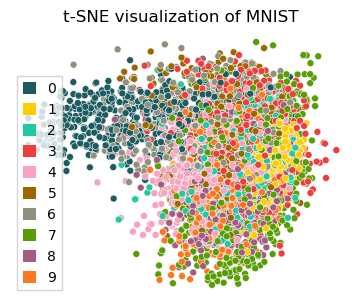

In [7]:
# Create a figure
fig = plt.figure(figsize=(15, 5))
ax = fig.add_subplot(1, 3, 1)
    
# Use Paradime's scatterplot utility to plot the embedding with class labels as colors
paradime.utils.plotting.scatterplot(
    embeddings[0],
    labels=target_subset,
    ax=ax,
    legend=True,
    legend_options={"loc": 3},
)
ax.set_title(f"t-SNE visualization of MNIST")

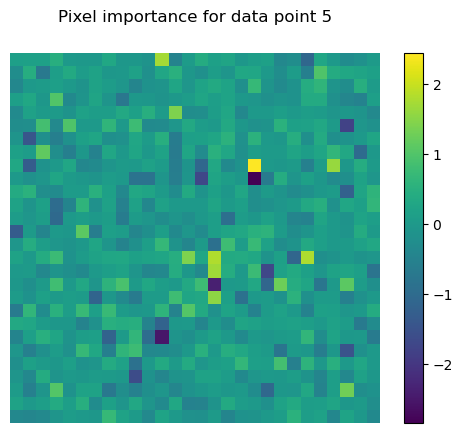

In [9]:
# Select a data point
idx = 6
data_point = mnist_subset[idx]

# Ensure the data point has the correct dimensions
if len(data_point.shape) == 1:
    data_point = data_point.view(1, -1)

# Move the data to the GPU
data_point = data_point.to('cuda')

# Get the output of each submodule and compute the mean
output = []
for i, submodule in enumerate(hybrid_tsne.model.submodules):
    submodule_output = submodule(data_point[:, i].unsqueeze(1))
    # Ensure the output is a 2D tensor
    if len(submodule_output.shape) == 1:
        submodule_output = submodule_output.view(1, -1)
    # Compute the mean of the output vector
    mean_contribution = th.mean(submodule_output)
    output.append(mean_contribution)

# Convert the list to a tensor
output = th.stack(output)

# Move the output back to the CPU for plotting
output = output.to('cpu')

# Convert the output tensor to a 2D image
output_2d = output.view(28, 28)

# Create a figure
fig, ax = plt.subplots()

# Create a heatmap
cax = ax.matshow(output_2d.detach().numpy(), cmap='viridis')

# Add a colorbar
fig.colorbar(cax)

# Set the title
ax.set_title('Pixel importance for data point {}'.format(idx))

# Hide the axes labels
ax.axis('off')

# Show the plot
plt.show()